In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pathlib
from lb2jpsil import lorentz
import random
from typing import Tuple
from scipy import optimize
import time

In [2]:
import matplotlib

font = {'size'   : 14}

matplotlib.rc('font', **font)

In [3]:
## Self explanatory
save_plots = True

In [4]:
## Create plots directory, if missing
repo_directory = str(pathlib.Path.home()) + '/lambda-emdm-measurement/'

plot_directory = (
    repo_directory + 'plots/'
    + 'smearing_comparison/'
)

pathlib.Path(plot_directory).mkdir(parents=True, exist_ok=True)

# A look at the PDF

In [5]:
def scalar_product(v1, v2):
    return v1[0] * v2[0] + v1[1] * v2[1] + v1[2] * v2[2]

In [6]:
## in eV
m_electron = 0.511e6
m_lambda = 1116e6

## in eV/T
bohr_magneton = 5.788e-5

## in eV s
hbar = 6.582e-16

## in m/s
c = 299792458.

In [7]:
## Assuming EDM is 0
def particle_magneton(m_particle):
    return bohr_magneton * m_electron / m_lambda

def phi_rot(g: float, Dy: float, beta: float, m_particle: float):
    muB = particle_magneton(m_particle)
    return g * Dy * muB / (beta * hbar * c)

In [8]:
def pdf(cos_theta, phi, sz=1., g=1.226, Dy=4, beta=1.):
    alpha = 0.732
    
    Phi_rot = phi_rot(g, Dy, beta, m_lambda)
    
    s = np.array([
        - sz * np.sin(Phi_rot),
        0,
        sz * np.cos(Phi_rot)
    ])
    
    k_hat = np.array([
        np.sin(np.arccos(cos_theta)) * np.cos(phi),
        np.sin(np.arccos(cos_theta)) * np.sin(phi),
        cos_theta
    ])
    
    return 1 + alpha * scalar_product(s, k_hat)

In [9]:
theta_min = -1
theta_max = 1

phi_min = -np.pi
phi_max = np.pi

bins = 100

theta_list = np.linspace(theta_min, theta_max, bins)
phi_list = np.linspace(phi_min, phi_max, bins)

theta_grid, phi_grid = np.meshgrid(theta_list, phi_list)
ys = pdf(theta_grid, phi_grid)

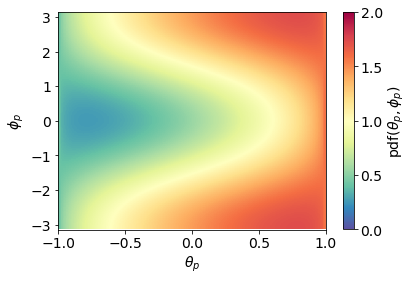

In [10]:
plt.imshow(ys,extent=[theta_min, theta_max, phi_min, phi_max], cmap='Spectral_r', origin='lower', aspect='auto')
#plt.imshow(ys, cmap='Spectral_r', origin='lower')

plt.clim(0,2)
plt.colorbar(label=r"$\mathrm{pdf}(\theta_p,\phi_p)$")
plt.xlabel(r"$\theta_p$")
plt.ylabel(r"$\phi_p$")
plt.show()

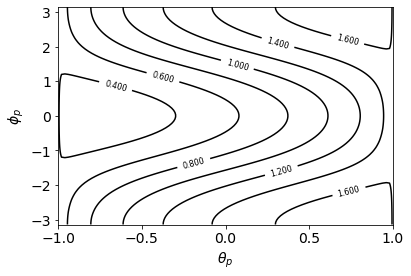

In [11]:
contours = plt.contour(theta_grid, phi_grid, ys, colors='k')
plt.clabel(contours, inline=True, fontsize=8)
plt.xlabel(r"$\theta_p$")
plt.ylabel(r"$\phi_p$")
plt.show()

# Event generation

In [12]:
class Generator:
    
    def __init__(self,
        event_number: int, 
        random_state: int = 2022,
        ctheta_resolution = None,
        phi_resolution = None,
        g: float = 1.226
    ):
        self._event_number = event_number
        self._random_state = random_state
        random.seed(random_state)
        
        self._ctheta_resolution = ctheta_resolution
        self._phi_resolution = phi_resolution
        
        if ctheta_resolution is not None:
            self._add_smearing_ctheta = True
        else:
            self._add_smearing_ctheta = False
        
        if phi_resolution is not None:
            self._add_smearing_phi = True
        else:
            self._add_smearing_phi = False
            
        self._g = g
    
    ## Getter and setter methods
    ### Event number
    @property
    def event_number(self) -> int:
        return self._event_number
    
    @event_number.setter
    def event_number(self, n) -> None:
        self._event_number = n
    
    ### Random state
    @property
    def random_state(self) -> int:
        return self._random_state
    
    @random_state.setter
    def random_state(self, n) -> None:
        self._random_state = n
        random.seed(n)
    
    ### Theta resolution
    @property
    def ctheta_resolution(self) -> float:
        return self._ctheta_resolution
    
    ### Phi resolution
    @property
    def phi_resolution(self) -> float:
        return self._phi_resolution
    
    ### Smear the angles?
    @property
    def add_smearing_ctheta(self) -> bool:
        return self._add_smearing_ctheta
    
    @property
    def add_smearing_phi(self) -> bool:
        return self._add_smearing_phi
    
    ### g for generation
    @property
    def g(self) -> float:
        return self._g
    
    ## Method to smear theta and phi with a gaussian of resolution sigma
    def smear_angle(self, angle: float, sigma: float):
        return random.gauss(angle, sigma)
    
    ## Method to smear cos(theta). This one only smears up to the -1, +1 edges.
    ## If the smearing would go past it, then it retries
    ## Note: it's not necessarily the right way to do this. The alternative
    ## is to fix the smear at -1 if the smeared angle would go past it.
    ## It would be a good idea to think critically at how the measurement is made
    ## and choose the technique to match possible resolution issues in real data.
    def smear_ctheta(self, theta: float, sigma: float):
        left_bound = -1
        right_bound = +1
        
        while True:
            reco_ctheta = self.smear_angle(theta, sigma)
            if left_bound <= reco_ctheta <= right_bound:
                break
        
        return reco_ctheta
    
    ## Method to smear phi. Here the smearing "wraps around" since -pi and pi are
    ## physically the same angle.
    def smear_phi(self, phi: float, sigma: float):
        reco_phi = self.smear_angle(phi, sigma)
        left_bound = -np.pi
        right_bound = np.pi
        
        if left_bound <= reco_phi <= right_bound:
            return reco_phi
        elif reco_phi < left_bound:
            return right_bound - (left_bound - reco_phi)
        elif reco_phi > right_bound:
            return left_bound + (reco_phi - right_bound)
        else:
            raise ValueError
        
    ## Individual generators
    def generate_omega(self) -> Tuple[float]:
        pdf_min = 0
        pdf_max = 2
                
        while True:
            ctheta = random.uniform(-1, 1)
            phi = random.uniform(-np.pi,np.pi)
            yref = random.uniform(pdf_min, pdf_max)
            
            if yref <= pdf(ctheta, phi, g=self._g):
                break
                
        if self._add_smearing_ctheta:
            ctheta = self.smear_ctheta(ctheta, self._ctheta_resolution)
        
        if self._add_smearing_phi:
            phi = self.smear_phi(phi, self._phi_resolution)
        
        return ctheta, phi
    
    ## For now it's very simplified: lambda momentum along z, maximal polarization s0 = 1, g=1.226, Dy = 4 T m, beta= 1
    def generate_event(self) -> dict:
        #own_vertex = [0,0, random.uniform(0,1000)]
        #momentum = [0,0,random.uniform(0,10000)]
        #decay_length = random.uniform(0,5000)
        
        #end_vertex = [
        #    random.uniform(-1000,1000),
        #    random.uniform(-1000,1000),
        #    random.uniform(5500,8500)
        #]
        
        ctheta, phi = self.generate_omega()
        
        event_dict = {
            #'L_OWNVERTEX_X': own_vertex[0],
            #'L_OWNVERTEX_Y': own_vertex[1],
            #'L_OWNVERTEX_Z': own_vertex[2],
            #'L_PX': momentum[0],
            #'L_PY': momentum[1],
            #'L_PZ': momentum[2],
            #'L_DECAYLENGTH': decay_length,
            #'L_ENDVERTEX_X': end_vertex[0],
            #'L_ENDVERTEX_Y': end_vertex[1],
            #'L_ENDVERTEX_Z': end_vertex[2],
            'COSTHETA': ctheta,
            'PHI': phi
        }
        
        return event_dict
    
    def generate_sample(self) -> pd.DataFrame:
        events = []
        
        for i in range(self._event_number):
            events.append(self.generate_event())
        
        df = pd.DataFrame(events)
        
        return df

## Generate events with all three smearings

In [13]:
psegen_perfect = Generator(event_number=1000000, random_state=2022)
psegen_nocross = Generator(event_number=1000000, random_state=2022, ctheta_resolution=0.097, phi_resolution=0.332)
psegen_current = Generator(event_number=1000000, random_state=2022, ctheta_resolution=0.253, phi_resolution=1.083)

In [14]:
df_perfect = psegen_perfect.generate_sample()
df_nocross = psegen_nocross.generate_sample()
df_current = psegen_current.generate_sample()

# A look at the distributions

## $\cos\theta_p$

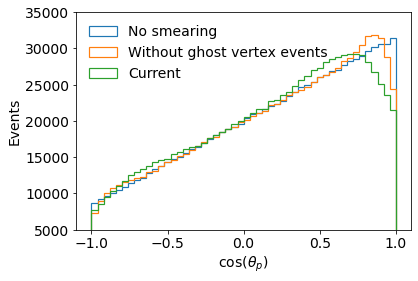

In [15]:
filename = 'ctheta_color'

common_params = {
    'bins': 50,
    'histtype': 'step',
    'linewidth': 1.2
}

perfect_params = {
    'label': 'No smearing',
    'color': 'tab:blue',
}

nocross_params = {
    'label': 'Without ghost vertex events',
    'color': 'tab:orange',
}

current_params = {
    'label': 'Current',
    'color': 'tab:green',
}


n_ctheta_perfect, ctheta_edges, _ = plt.hist(df_perfect['COSTHETA'], **common_params, **perfect_params)
n_ctheta_nocross, _, _ = plt.hist(df_nocross['COSTHETA'], **common_params, **nocross_params)
n_ctheta_current, _, _ = plt.hist(df_current['COSTHETA'], **common_params, **current_params)

plt.legend(frameon=False, loc='upper left')
plt.xlabel(r"$\cos(\theta_p)$")
plt.ylabel("Events")
plt.ylim(5000,35000)

if save_plots:
    plt.savefig(plot_directory + filename + '.pdf', bbox_inches = 'tight')
    plt.savefig(plot_directory + filename + '.png', bbox_inches = 'tight', dpi=150)

plt.show()

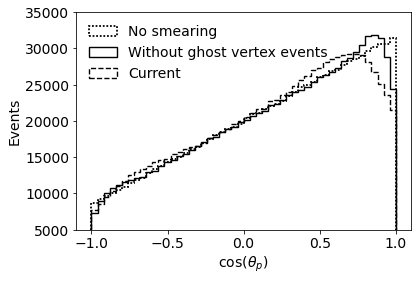

In [16]:
filename = 'ctheta_bw'

common_params = {
    'bins': 50,
    'histtype': 'step',
    'facecolor': 'none',
    'edgecolor': 'black'
}

perfect_params = {
    'label': 'No smearing',
    'linewidth': 1.8,
    'linestyle': (0, (1,1))
}

nocross_params = {
    'label': 'Without ghost vertex events',
    'linewidth': 1.4,
    'linestyle': 'solid'
}

current_params = {
    'label': 'Current',
    'linewidth': 1.4,
    'linestyle': 'dashed'
}


plt.hist(df_perfect['COSTHETA'], **common_params, **perfect_params)
plt.hist(df_nocross['COSTHETA'], **common_params, **nocross_params)
plt.hist(df_current['COSTHETA'], **common_params, **current_params)

plt.legend(frameon=False, loc='upper left')
plt.ylim(5000,35000)
plt.xlabel(r"$\cos(\theta_p)$")
plt.ylabel("Events")

if save_plots:
    for extension in ['.pdf', '.png']:
        plt.savefig(plot_directory + filename + extension, bbox_inches = 'tight')

plt.show()

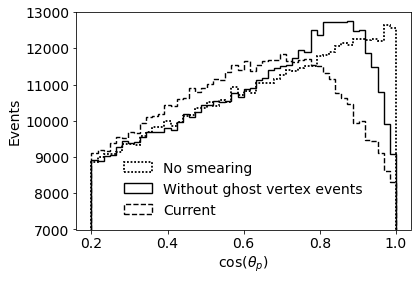

In [17]:
filename = 'ctheta_bw_right'

common_params = {
    'bins': 50,
    'histtype': 'step',
    'facecolor': 'none',
    'edgecolor': 'black',
    'range': (0.2, 1.)
}

perfect_params = {
    'label': 'No smearing',
    'linewidth': 1.8,
    'linestyle': (0, (1,1))
}

nocross_params = {
    'label': 'Without ghost vertex events',
    'linewidth': 1.4,
    'linestyle': 'solid'
}

current_params = {
    'label': 'Current',
    'linewidth': 1.4,
    'linestyle': 'dashed'
}


plt.hist(df_perfect['COSTHETA'], **common_params, **perfect_params)
plt.hist(df_nocross['COSTHETA'], **common_params, **nocross_params)
plt.hist(df_current['COSTHETA'], **common_params, **current_params)

plt.legend(frameon=False, loc='lower center')
plt.ylim(7000,13000)
plt.xlabel(r"$\cos(\theta_p)$")
plt.ylabel("Events")

if save_plots:
    for extension in ['.pdf', '.png']:
        plt.savefig(plot_directory + filename + extension, bbox_inches = 'tight')

plt.show()

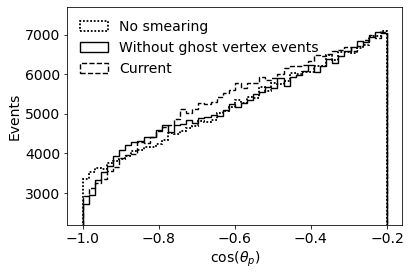

In [18]:
filename = 'ctheta_bw_left'

common_params = {
    'bins': 50,
    'histtype': 'step',
    'facecolor': 'none',
    'edgecolor': 'black',
    'range': (-1., -0.2)
}

perfect_params = {
    'label': 'No smearing',
    'linewidth': 1.8,
    'linestyle': (0, (1,1))
}

nocross_params = {
    'label': 'Without ghost vertex events',
    'linewidth': 1.4,
    'linestyle': 'solid'
}

current_params = {
    'label': 'Current',
    'linewidth': 1.4,
    'linestyle': 'dashed'
}


plt.hist(df_perfect['COSTHETA'], **common_params, **perfect_params)
plt.hist(df_nocross['COSTHETA'], **common_params, **nocross_params)
plt.hist(df_current['COSTHETA'], **common_params, **current_params)

plt.legend(frameon=False, loc='upper left')
plt.ylim(2200,7700)
plt.xlabel(r"$\cos(\theta_p)$")
plt.ylabel("Events")

if save_plots:
    for extension in ['.pdf', '.png']:
        plt.savefig(plot_directory + filename + extension, bbox_inches = 'tight')

plt.show()

In [19]:
ctheta_midpoints = (ctheta_edges[1:] + ctheta_edges[:-1])/2

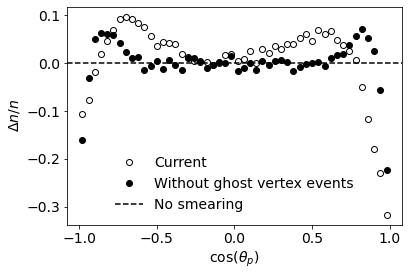

In [20]:
filename = 'ctheta_bw_residuals'

common_params = {
    'linestyle': '',
    'marker': 'o',
    'markeredgecolor': 'black'
}

nocross_params = {
    'label': 'Without ghost vertex events',
    'markerfacecolor': 'black',
}

current_params = {
    'label': 'Current',
    'markerfacecolor': 'none',
}

plt.plot(ctheta_midpoints, (n_ctheta_current - n_ctheta_perfect)/n_ctheta_perfect, **common_params, **current_params)
plt.plot(ctheta_midpoints, (n_ctheta_nocross - n_ctheta_perfect)/n_ctheta_perfect, **common_params, **nocross_params)
plt.axhline(0, color='k', linestyle='--', label='No smearing')

plt.xlabel(r"$\cos(\theta_p)$")
plt.ylabel(r"$\Delta n / n$")
#plt.ylim(-0.15, 0.4)

plt.xlabel(r"$\cos(\theta_p)$")
plt.ylabel(r"$\Delta n / n$")
plt.legend(frameon=False, loc='lower center')

if save_plots:
    for extension in ['.pdf', '.png']:
        plt.savefig(plot_directory + filename + extension, bbox_inches = 'tight')

plt.show()

## $\phi_p$

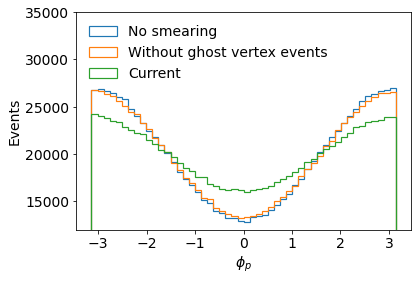

In [21]:
filename = 'phi_color'

common_params = {
    'bins': 50,
    'histtype': 'step',
    'linewidth': 1.2
}

perfect_params = {
    'label': 'No smearing',
    'color': 'tab:blue',
}

nocross_params = {
    'label': 'Without ghost vertex events',
    'color': 'tab:orange',
}

current_params = {
    'label': 'Current',
    'color': 'tab:green',
}


n_phi_perfect, phi_edges, _ = plt.hist(df_perfect['PHI'], **common_params, **perfect_params)
n_phi_nocross, _, _ = plt.hist(df_nocross['PHI'], **common_params, **nocross_params)
n_phi_current, _, _ = plt.hist(df_current['PHI'], **common_params, **current_params)

plt.legend(frameon=False, loc='upper left')
plt.xlabel(r"$\phi_p$")
plt.ylabel("Events")
plt.ylim(12000,35000)

if save_plots:
    plt.savefig(plot_directory + filename + '.pdf', bbox_inches = 'tight')
    plt.savefig(plot_directory + filename + '.png', bbox_inches = 'tight', dpi=150)

plt.show()

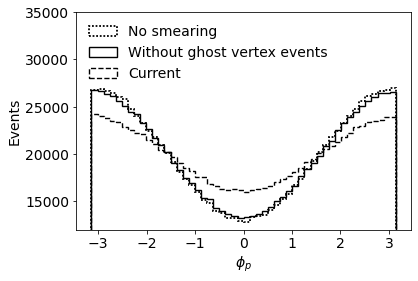

In [22]:
filename = 'phi_bw'

common_params = {
    'bins': 50,
    'histtype': 'step',
    'facecolor': 'none',
    'edgecolor': 'black'
}

perfect_params = {
    'label': 'No smearing',
    'linewidth': 1.8,
    'linestyle': (0, (1,1))
}

nocross_params = {
    'label': 'Without ghost vertex events',
    'linewidth': 1.4,
    'linestyle': 'solid'
}

current_params = {
    'label': 'Current',
    'linewidth': 1.4,
    'linestyle': 'dashed'
}


plt.hist(df_perfect['PHI'], **common_params, **perfect_params)
plt.hist(df_nocross['PHI'], **common_params, **nocross_params)
plt.hist(df_current['PHI'], **common_params, **current_params)

plt.legend(frameon=False, loc='upper left')
plt.ylim(12000,35000)
plt.xlabel(r"$\phi_p$")
plt.ylabel("Events")

if save_plots:
    for extension in ['.pdf', '.png']:
        plt.savefig(plot_directory + filename + extension, bbox_inches = 'tight')

plt.show()

In [23]:
phi_midpoints = (phi_edges[1:] + phi_edges[:-1])/2

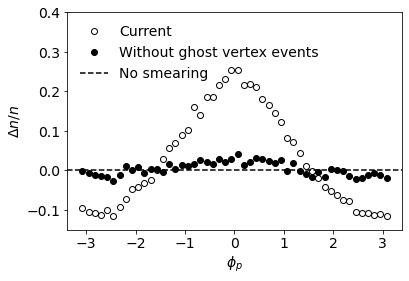

In [24]:
filename = 'phi_residuals'

common_params = {
    'linestyle': '',
    'marker': 'o',
    'markeredgecolor': 'black'
}

nocross_params = {
    'label': 'Without ghost vertex events',
    'markerfacecolor': 'black',
}

current_params = {
    'label': 'Current',
    'markerfacecolor': 'none',
}

plt.plot(phi_midpoints, (n_phi_current - n_phi_perfect)/n_phi_perfect, **common_params, **current_params)
plt.plot(phi_midpoints, (n_phi_nocross - n_phi_perfect)/n_phi_perfect, **common_params, **nocross_params)
plt.axhline(0, color='k', linestyle='--', label='No smearing')

plt.xlabel(r"$\cos(\theta_p)$")
plt.ylabel(r"$\Delta n / n$")
plt.ylim(-0.15, 0.4)

plt.xlabel(r"$\phi_p$")
plt.ylabel(r"$\Delta n / n$")
plt.legend(frameon=False, loc='upper left')

if save_plots:
    for extension in ['.pdf', '.png']:
        plt.savefig(plot_directory + filename + extension, bbox_inches = 'tight')

plt.show()